# Customer Segmentation With A Online Transaction Dataset

### Table of Contents
* [Step 1: Import necessary libraries and modules](#chapter1)
* [Step 2: Load the dataset](#chapter2)
    * [2.1 Characteristics of online_transactions_cleaned](#section_2_1)
    * [2.2 Observation in the statistical values](#section_2_2)
    * [2.3 How to handle the canceled orders?](#section_2_3)
* [Step 3: Explore the dataset (with SQL Queries)](#chapter3)
    * [3.1 What are the top ten most popular geographical locations? ](#section_3_1)
    * [3.2 Which country has spent the most...?](#section_3_2)
        * [3.2.1  ... by order value](#sub_section_3_2_1)
        * [3.2.2  ... by item quantity](#sub_section_3_2_2)
    * [3.3 Looking at seasonality](#section_3_3)
        * [3.3.1 How many unique invoices per month in 2011?](#sub_section_3_3_1)
        * [3.3.2 Which day of the week has the highest number of transactions?](#sub_section_3_3_2)
    * [3.4 Which customers have purchased the most?](#section_3_4)
    * [3.5 Which customers are recurring customers?](#section_3_5)
* [Step 4: Creating Customer Categories...](#chapter4)
    * [4.1 ... by frequency](#section_4_1)
    * [4.2 ... by sales amount](#section_4_2)
* [Step 5: Customer segmentation with K-Means clustering](#chapter5)
    * [5.1 Aggregating data at customer level](#section_5_1)
    * [5.2 Removing outliers](#section_5_2)
    * [5.3 Applying the Elbow Method](#section_5_3)
    * [5.4 Implementing K-Means clustering](#section_5_4)
    * [5.5 Vizualize the clusters](#section_5_5)
    * [5.6 Analysis of the customer clusters](#section_5_6)

## 1. Import necessary libraries and modules <a id="chapter1"></a>

In [15]:
import pandas as pd
import numpy as np
import sqlite3

In [6]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats

# For Windows users: Set the number of threads to 1 to avoid problems with KMeans
import os
os.environ['OMP_NUM_THREADS'] = '1'


## 2. Load the dataset  <a id="chapter2"></a>

In [18]:
# connect to db (cleaned w/ 3 tables)
conn = sqlite3.connect("data/bootcamp_db")

In [19]:
conn

In [20]:
# Doublecheck of the db contains 3tables
sql_query = """SELECT name 
               FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]



The database contains three tables:
- online_transactions
- stock_description
- online_transactions_cleaned

In a previous exercise the first two tabels has been explored and joined together. The result ist the third table 'online_transactions_cleaned'.

### 2.1 Characteristics of online_transactions_cleaned' <a id="section_2_1"></a>

In a previous project:
-  a left JOIN query has added the description from 'stock_description' to the 'online_transactions' table<br>

The left join query has considered:
- Filling in UNKNOWN' when description is null 
- Creating a the column total_amount_spent by price*quantity 
- Removing rows where the col. stock_code is '?'
- Removing rows where the col. stock_code is BANK CHARGES', 'POST', 'D', 'M', 'CRUK'
- Removing rows where customer_id is blank

The result is the table 'online_transactions_cleaned'<br>

In 'online_transactions_cleaned' the duplicates have been already removed

In [21]:
#Create a dataframe from the table online_transactions_cleaned
ot_cleaned = pd.read_sql_query("""SELECT * FROM online_transactions_cleaned""", conn)

In [22]:
type(ot_cleaned)

pandas.core.frame.DataFrame

In [23]:
ot_cleaned.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom


In [24]:
ot_cleaned.shape 

(399841, 9)

In [25]:
ot_cleaned.describe()

,price,quantity,total_order_value
count,399841.000000,399841.000000,399841.000000
mean,2.952914,12.224359,20.716904
std,7.317593,250.788860,425.471765
min,0.000000,-80995.000000,-168469.600000
25%,1.250000,2.000000,4.250000
50%,1.950000,5.000000,11.580000
75%,3.750000,12.000000,19.500000
max,1599.260000,80995.000000,168469.600000


### 2.2 Observation in the statistical values <a id="section_2_2"></a>
We can see negative values at the minimum for 'quantitiy' and 'total_order_value'. That's unusual and illogical. The minimum should be at least 0.00
Most propably this numbers come form canceled orders. They lead to negative values in 'quantity' and 'price'.
The cancelation entries contain a "C" in the invoice number and have the negativ numbers. The orginial orders haven't been removed and are still in the table.

In [26]:
#Example of an original and cancelled order in the same table.

sql_query_2 = pd.read_sql_query( """
SELECT invoice, description,quantity, invoice_date, total_order_value 
FROM online_transactions_cleaned otc 
WHERE quantity LIKE '%80995%';
""", conn)

sql_query_2

,invoice,description,quantity,invoice_date,total_order_value
0,581483,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,168469.6
1,C581484,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,-168469.6


### 2.3 How to handle the canceled orders? <a id="section_2_3"></a>
There are 8507 entries containing an 'c' in the invoices number. Together with the original order that are 17,014 entries in total. 
This are 4,25% of the whole data set.

For the moment: <br>
1) I've decided to postpone finding the solution for elimating the 4,25% of data and concentrate on the steps for data exploration and customer segmentation 
2) I'll go with the workaround by excluding all negative values in 'quantity" and 'price' and handle the data, if no cancelation have been made.


In [27]:
#Exlude the data entries with negative values in 'quantity" and 'price'
query_cancelled= """SELECT * 
                    FROM online_transactions_cleaned 
                    WHERE quantity > 0
                        ;"""
otc_fixed = pd.read_sql(query_cancelled, conn)

In [17]:
otc_fixed.describe() 

,price,quantity,total_order_value
count,391334.000000,391334.000000,391334.000000
mean,2.920468,13.174199,22.372879
std,7.267548,181.871884,310.911086
min,0.000000,1.000000,0.000000
25%,1.250000,2.000000,4.950000
50%,1.950000,6.000000,11.900000
75%,3.750000,12.000000,19.800000
max,1599.260000,80995.000000,168469.600000


After excluding every entry where the quantity value lower than 0. 
We can see that 
- the average price of purchased products is around 3€
- the average amount of products per order is 13 items
- the average total value per ordered product type is 22,37€
- the most expensiv ordered product costs 1599€
- the product, which was ordered with the highest number per order, was ordered 80995 times.
- the highest total order value for one product in one order is 168469€

##  3. Explore the dataset (with SQL queries) <a id="chapter3"></a>

To get to know the dataset better and to show that I'm capable of SQL queries and EDA in Python

### 3.1 What are the top ten most popular geographical locations? <a id="section_3_1"></a>


In [18]:
#How many different types of stocks did all customers purchase?

query_stocks = pd.read_sql_query( """
select count (DISTINCT stock_code) as numbers_of_stocks
from online_transactions_cleaned otc;
""", conn)

query_stocks

,numbers_of_stocks
0,3679


In [19]:
# What are the Top 10 Locations from where customers were ordering from?

country_counts = otc_fixed['country'].value_counts()

top_10_countries = country_counts.head(10)

print(top_10_countries)

country
United Kingdom    348940
Germany             8644
France              8021
EIRE                7226
Spain               2418
Netherlands         2326
Belgium             1935
Switzerland         1811
Portugal            1416
Australia           1183
Name: count, dtype: int64


<Axes: xlabel='country'>

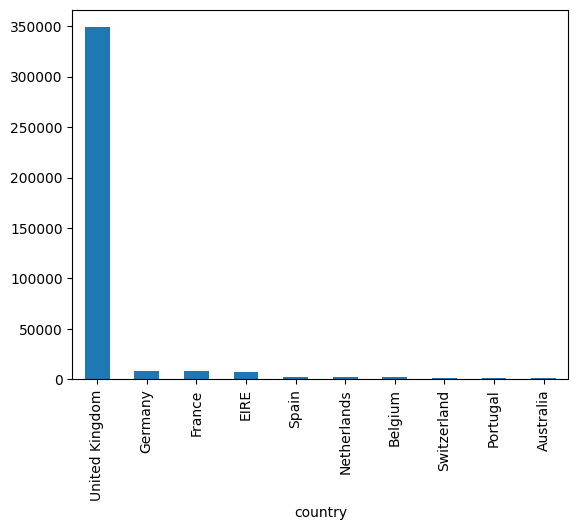

In [20]:
#quick&simple bar chart visualization
top_10_countries.plot(kind='bar')

We see very clear that the huge majority (89%) of the placed orders are made by customers who are located in the UK. 

### 3.2 Which country has spent the most...? <a id="section_3_2"></a>

#### 3.2.1 -> ... by order value  <a id="sub_section_3_2_1"></a>


In [27]:
total_sales_countries = pd.read_sql_query(
    """SELECT country, SUM(total_order_value) AS total_sales_volume
    FROM online_transactions_cleaned otc
    WHERE total_order_value > 0  /*necesseary in a sql querry because the canceled orders still exist in the database*/
    GROUP BY country
    ORDER BY SUM (total_order_value) DESC
    LIMIT 10;""", conn)

While using a sql query it is important to use "WHERE total_order_value > 0", because the canceled orders still exist in the table "online_transactions_cleaned otc"

In [28]:
total_sales_countries

,country,total_sales_volume
0,United Kingdom,7255684.833
1,Netherlands,283889.340
2,EIRE,261888.120
3,Germany,205381.150
4,France,183987.940
5,Australia,138103.810
6,Spain,55706.560
7,Switzerland,52441.950
8,Japan,37416.370
9,Belgium,36927.340


<b>Observation:</b> Of course, the biggest sales volume is made by UK customers with 7,255,684.

#### 3.2.2 -> ... by item quantity <a id="sub_section_3_2_2"></a>


It is likely, but it does not necessarily mean, that customers from the UK are also ordering the largest quantity of products. The total sales amount is dependen on the stock price. <br>Maybe there are customers who order less items, but more expensive items.<br>
That's why I chose to also look at how many items are ordered by customers' country.

In [63]:
total_soldquantity_countries = pd.read_sql_query(
    """SELECT country, SUM(quantity) AS total_solditems
    FROM online_transactions_cleaned otc
     WHERE total_order_value > 0
    GROUP BY country
    ORDER BY  SUM(quantity) DESC
    LIMIT 10;""", conn)

In [64]:
total_soldquantity_countries

,country,total_solditems
0,United Kingdom,4234058
1,Netherlands,200258
2,EIRE,140131
3,Germany,118032
4,France,110597
5,Australia,83890
6,Sweden,36037
7,Switzerland,29980
8,Spain,27724
9,Japan,26016


<b>Observation:</b>
Maybe not a big surprise, but we see that also the order of the top ten countries remains unchanged.

In [65]:
#Alternativ approach with groupby instead of a SQL query

# Segmenting by Top 10 countries
#country_segment_spent = customer_data.groupby('country').agg(
   # num_orders=('invoice', 'nunique'),
    #total_order_value=('total_order_value', 'sum')
#).sort_values('total_order_value', ascending=False).reset_index()

#country_segment_spent.head(10)

### 3.3 Looking at seasonality<a id="section_3_3"></a>


I would like to look at whether the orders are consistent throughout the year or whether there are seasonal peculiarities

In [30]:
#Checking which datatype "invoice_date" has
otc_fixed.dtypes

invoice               object
stock_code            object
description           object
invoice_date          object
price                float64
quantity               int64
total_order_value    float64
customer_id           object
country               object
dtype: object

In [31]:
# Convert invoice_date into datetime format
otc_fixed['invoice_date'] = pd.to_datetime(otc_fixed['invoice_date'])

In [32]:
#counter check for 'dtype'
print(otc_fixed['invoice_date'].head())

0   2010-12-01 08:45:00
1   2010-12-01 09:02:00
2   2010-12-01 09:37:00
3   2010-12-01 09:41:00
4   2010-12-01 09:41:00
Name: invoice_date, dtype: datetime64[ns]


#### 3.3.1 How many unique invoices per month in 2011? <a id="sub_section_3_3_1"></a>

I would like to look at whether the orders are consistent throughout the year or whether there are seasonal peculiarities.<br>
The dataset covers the December of 2010 and the whole year 2011.

In [33]:
#How many unique invoices per month in 2011?

#Filter year 2011
otc_fixed_2011 = otc_fixed[otc_fixed['invoice_date'].dt.year == 2011].copy()

# Create a variable to extract the month
otc_fixed_2011['Month'] = otc_fixed_2011['invoice_date'].dt.month

# Create a df while using the groupby function to count the number of unique invoices per month
monthly_invoices_2011 = pd.DataFrame(otc_fixed_2011.groupby(['Month']).nunique()['invoice'])

print(monthly_invoices_2011)

       invoice
Month         
1          983
2          993
3         1312
4         1139
5         1544
6         1390
7         1321
8         1269
9         1740
10        1903
11        2643
12         776


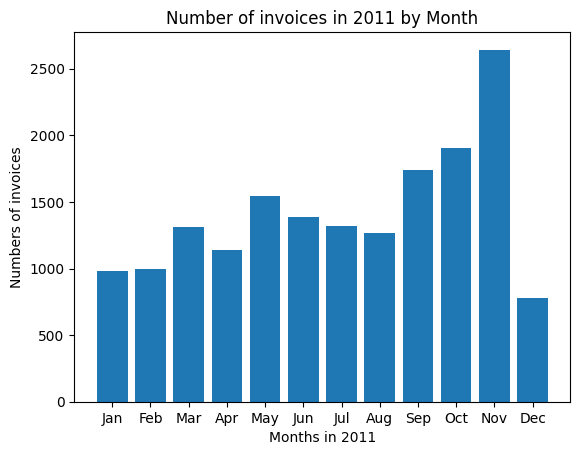

In [70]:
# Plotting the invoices per month in 2011 

plt.bar(monthly_invoices_2011.index, monthly_invoices_2011['invoice'])
plt.title ("Number of invoices in 2011 by Month")
plt.xlabel('Months in 2011')
plt.ylabel('Numbers of invoices')
plt.xticks(range (1,13))
plt.xticks(monthly_invoices_2011.index, 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<b>Observation:</b>
- In the middle of the year (may, june) is a slight peak.
- From September on the invoices rise with a peak in November. <b>Assuming:</b> preparing for the Christmas season

#### 3.3.2 Which day of the week has the highest number of transactions? <a id="sub_section_3_3_2"></a>

In [41]:
# Create week day name
otc_fixed_2011['weekday_name'] = otc_fixed_2011['invoice_date'].dt.day_name()

# Count invoices per week day
weekday_counts = otc_fixed_2011['weekday_name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [42]:
print(weekday_counts)

weekday_name
Monday       60029.0
Tuesday      62440.0
Wednesday    62508.0
Thursday     73293.0
Friday       50831.0
Saturday         NaN
Sunday       56652.0
Name: count, dtype: float64


<Axes: xlabel='weekday_name'>

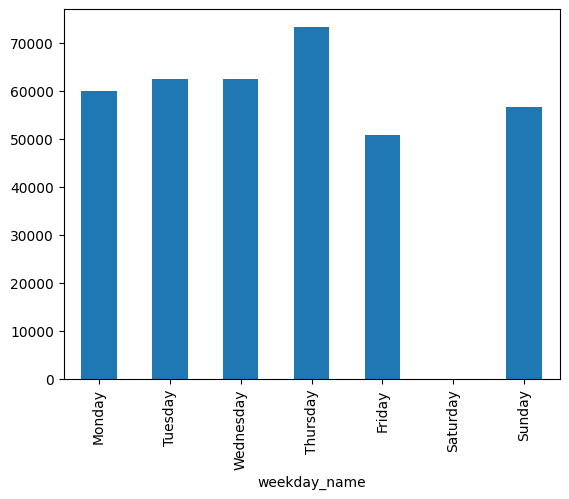

In [73]:
# simple & quick visualisation

weekday_counts.plot(kind='bar')

<b>Observation:</b> <br>
- On Thursdays the order volume is slightly higher than the rest of the week.
- For the rest of the weekdays the orders are distributed almost evenly, except for Saturdays.
- It is striking that no orders were placed on Saturdays.<br>

## 3.4 Which customers have purchased the most ? <a id="section_3_4"></a>

Let's try to get some insights on the customers.

In [43]:
# Calculating/grouping the sum of order value per customer_id 
otc_fixed_salesbycustomer = pd.DataFrame(otc_fixed.groupby(['customer_id']).sum(numeric_only=True)['total_order_value'])

# and sort them in a descending order
otc_fixed_salesbycustomer.sort_values(by=['total_order_value'],ascending = False)

,total_order_value
customer_id,
u14646,279138.02
u18102,259657.30
u1745,194390.79
u16446,168472.50
u14911,140336.83
...,...
u17956,12.75
u14792,6.20
u16454,5.90


In [44]:
# Average spending by customer
otc_fixed_salesbycustomer['total_order_value'].mean()

2019.669700807382

In [45]:
# Which customers purchased above the average? (= high profile customers)

high_profil_customer = otc_fixed_salesbycustomer[(otc_fixed_salesbycustomer['total_order_value']> 2019.669700807382)]


In [47]:
high_profil_customer.sort_values(by=['total_order_value'],ascending = False)


,total_order_value
customer_id,
u14646,279138.02
u18102,259657.30
u1745,194390.79
u16446,168472.50
u14911,140336.83
...,...
u12501,2025.39
u16409,2022.98
u14482,2022.81


<b>Observation:</b> <br>
873 of 4335 customers (that are 20%) have spent above the average customer per order and can be categorized as high profile customers.

The section "creating customer categories ... by sales amount" will also cover the categorie, but by using a if-else-statments.


## 3.5 Which customers are recurring customers ? <a id="section_3_5"></a>

Let's see if there are customers that ordered more than once and how often have the average customers odered items.

In [51]:
# How many times have each customer placed an order?

otc_fixed_frequency = pd.DataFrame(otc_fixed.groupby('customer_id')['invoice'].nunique().reset_index())
otc_fixed_frequency.columns = ['customer_id', 'frequency']

otc_fixed_frequency

,customer_id,frequency
0,u12346,1
1,u12347,7
2,u12348,4
3,u12349,1
4,u1235,1
...,...,...
4330,u1828,1
4331,u18281,1
4332,u18282,2
4333,u18283,16


In [49]:
# Customers, who ordered more than 1x are "recurring customers" ->  = recur_custom
recur_custom = otc_fixed_frequency[(otc_fixed_frequency['frequency']> 1)]

# Sort he recur_custom by a descending order
recur_custom.sort_values(by=['frequency'],ascending = False)    

,customer_id,frequency
326,u12748,206
1880,u14911,199
4008,u17841,124
562,u13089,97
2177,u15311,91
...,...,...
2015,u15101,2
3334,u16897,2
2007,u15092,2
2003,u15088,2


In [147]:
#Let's have a look what we can say about the average recurring cusomter:
recur_custom.describe()

,frequency
count,2829.000000
mean,5.974549
std,8.996899
min,2.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,206.000000


<b>Observation:</b> <br>
- we have 2829 of 4335 customers who purchased more the once. That are 65% of the customers.
- at least one customer ordered 206 times

The <b>average customer</b> has ordered approx. 6 times and purchased an order value of 2019€ per order.

## 4. Creating customer categories ... <a id="chapter4"></a>
### 4.1 ... by frequency <a id="section_4_1"></a>


Additionally I wanted to show another way of creating categories with if-else-statements.

I've defined three categories.
- Occasional customer: If the average customer has ordered 6 times, I've decided that the occasional customer is defined by 5 orders or less
- Regular customer: between 6 and 20 orders. If a customer ordered up to 20 times in one year, means they've placed an order every second week. I considered this regular customer.
- Loyal customer: someone who ordered more than 20 times, I've considered a loval customer

In [57]:
# Creating the new column "frequency" with the number of orders per customer

def categorize_customers(frequency):
    if 1 <= frequency <= 5:
        return 'Occasional Customers'
    elif 6 <= frequency <= 20:
        return 'Regular Customers'
    else:
        return 'Loyal Customers'

otc_fixed_frequency['category'] = otc_fixed_frequency['frequency'].apply(categorize_customers)

otc_fixed_frequency.head(10)


,customer_id,frequency,category
0,u12346,1,Occasional Customers
1,u12347,7,Regular Customers
2,u12348,4,Occasional Customers
3,u12349,1,Occasional Customers
4,u1235,1,Occasional Customers
5,u12352,7,Regular Customers
6,u12353,1,Occasional Customers
7,u12354,1,Occasional Customers
8,u12355,1,Occasional Customers
9,u12356,3,Occasional Customers


In [58]:
print(otc_fixed_frequency['category'].value_counts())

category
Occasional Customers    3470
Regular Customers        771
Loyal Customers           94
Name: count, dtype: int64


<Axes: xlabel='category'>

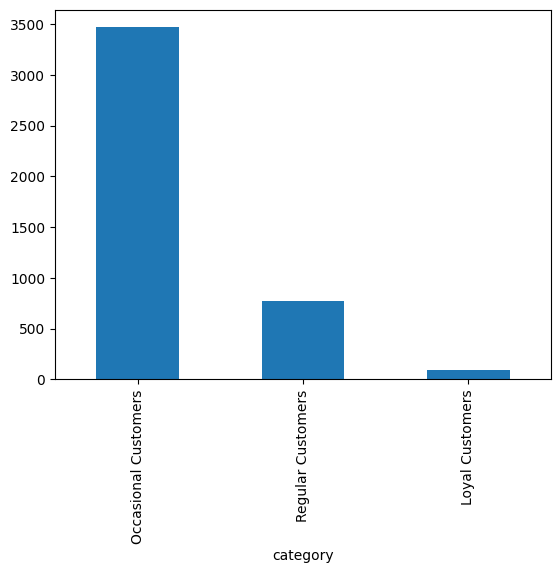

In [59]:
(otc_fixed_frequency['category'].value_counts()).plot(kind='bar')

<b>Observation:</b> <br>
- The vast majority (3470 of 4335, 80%) are ocassional customers
- Around 18% (771 customers) can be considered as regular customers
- 2 % can be considered as loyal customers, because they placed 20 and more orders

### 4.2 ...by sales amount <a id="section_4_2"></a>

- Creating three categories of customeres based on their total sales amount. 
- The amount of 2019 Euros is the average order value. I've decided that every customer who have spent more is a high-spending customer.
- Half of 2019 is rounded down to 500 euros. I've decided that every customer who have spent less than 500 Euro is a low-spending customer.
- Between 500 and 2019 will be mid-spending customers.

Therefore I defined a function with an if-else-statement to create a new column for the three categories.

In [66]:
def categorize_salesamount(otc_fixed_salesbycustomer):
    if 1 <= otc_fixed_salesbycustomer <= 499:
        return 'Low-spending Customers'
    elif 500 <= otc_fixed_salesbycustomer <= 2019:
        return 'Mid-spending Customers'
    else:
        return 'High-spending Customers'

otc_fixed_salesbycustomer['sales category'] = otc_fixed_salesbycustomer['total_order_value'].apply(categorize_salesamount)

otc_fixed_salesbycustomer.head(10)

,total_order_value,sales category
customer_id,,
u12346,77183.60,High-spending Customers
u12347,4310.00,High-spending Customers
u12348,1437.24,Mid-spending Customers
u12349,1457.55,Mid-spending Customers
u1235,294.40,Low-spending Customers
u12352,1385.74,Mid-spending Customers
u12353,89.00,Low-spending Customers
u12354,1079.40,Mid-spending Customers
u12355,459.40,Low-spending Customers


In [67]:
print(otc_fixed_salesbycustomer['sales category'].value_counts())

sales category
Low-spending Customers     1775
Mid-spending Customers     1682
High-spending Customers     878
Name: count, dtype: int64


<Axes: xlabel='sales category'>

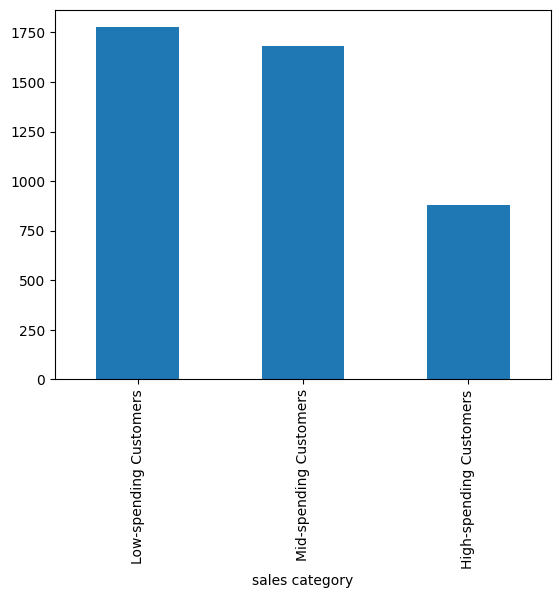

In [62]:
(otc_fixed_salesbycustomer['sales category'].value_counts()).plot(kind='bar')

<b>Observation:</b> <br>
- The majority of customers are low-spending and mid-sepending customers. Together they are 80%. <br>

<b>A few assumptions based on the created categories:</b> <br>
- There are overlappings of the 80% of low-/mid-spending customers and the 80% of the occasional customers.
- The occasional customers tend to spend less than the average. Maybe the occasional customers ordered a small amount of items and/or items in the lower price range.
- Maybe they are not yet familiar with the online shop and wanted to test the qualilty of the items and the shop itself without taking a big risk.
- Maybe they are smaller resellers who don't have a huge turnovers in generell, so they order this amount which they are capable of selling
- In the worst case the occasional customers weren't satisfied with the so far ordered products and that is why they haven't ordered again or more often
- Or maybe they just need a bit of an incentive to order again.



## 5. Customer segmentation with K-Means clustering <a id="chapter5"></a>

As a third opportunity I would like to test K-Means clustering to see which commonalities and differences the model will find throughout the customers.


### 5.1 Aggregating data at customer level <a id="section_5_1"></a>
Aggregation on customer level to analyze each customer’s purchasing behavior. <br> <br>
To do this, 
- the numbers of average days since last purchases are calculated and summarised in the new column ‘recency’  using a lambda function,
- the numbers of invoices/transactions per customers are counted and summarised in the new column ‘frequency’,
- and the total of all orders per customers are summarized column ‘total_order_value’.

In [70]:
# Aggregate data by CustomerID
customer_data = otc_fixed.groupby('customer_id').agg({
    'invoice_date': lambda x: (x.max() - x.min()).days,
    'invoice': 'count',
    'total_order_value': 'sum'
}).rename(columns={'invoice_date': 'recency', 'invoice': 'frequency'})


In [71]:
customer_data.head()

,recency,frequency,total_order_value
customer_id,,,
u12346,0,1,77183.60
u12347,365,182,4310.00
u12348,282,27,1437.24
u12349,0,72,1457.55
u1235,0,16,294.40


### 5.2 Removing outliers <a id="section_5_2"></a>

To make sure that no unwanted outliers wont't distort the upcoming result, I will remove possible outliers.

First I'll check visually with the help of a boxplot chart, if there are outliers.

##### Visualise the Outliers

recency: 


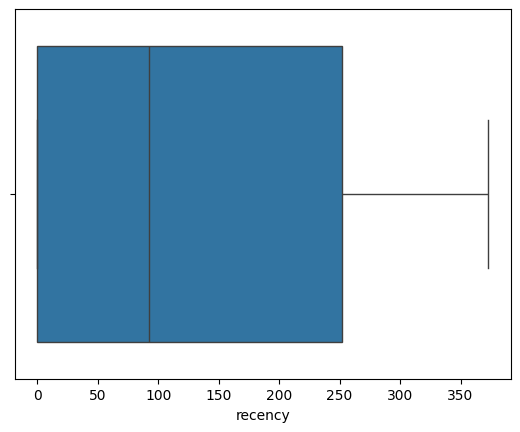

frequency: 


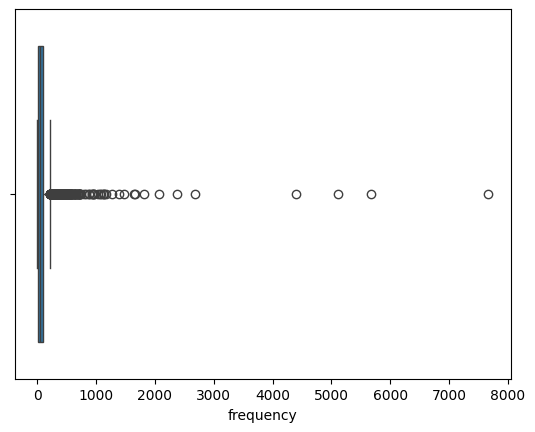

total_order_value: 


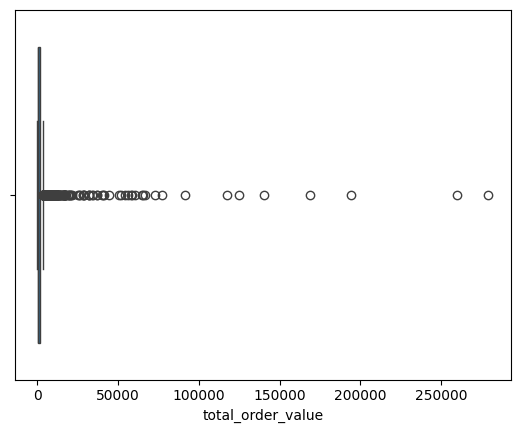

In [72]:
list1 = ['recency','frequency','total_order_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=customer_data[str(i)])
    plt.show()

In [78]:
#Reindexing, so that the customer_id is not the index anymore, but rather a column, that can be filtred out
new_df_reindexed = customer_data.reset_index()
new_df_reindexed.head()

,customer_id,recency,frequency,total_order_value
0,u12346,0,1,77183.60
1,u12347,365,182,4310.00
2,u12348,282,27,1437.24
3,u12349,0,72,1457.55
4,u1235,0,16,294.40


In [80]:
# Removing the customer_id column because for the following step it not needed
new_df = new_df_reindexed[['recency','frequency','total_order_value']]

# Removing the outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
customer_data_ol_removed = new_df[filtered_entries]

# "..._ol_removed" stands for outliers_removed

In [81]:
customer_data_ol_removed.head()

,recency,frequency,total_order_value
1,365,182,4310.00
2,282,27,1437.24
3,0,72,1457.55
4,0,16,294.40
5,260,77,1385.74


In [143]:
customer_data_ol_removed.shape

(4284, 3)

 51 outliers has been removed from 4335 customers' data.

### 5.3 Applying the Elbow Method <a id="section_5_3"></a>
To determine the optimal number of clusters for KMeans

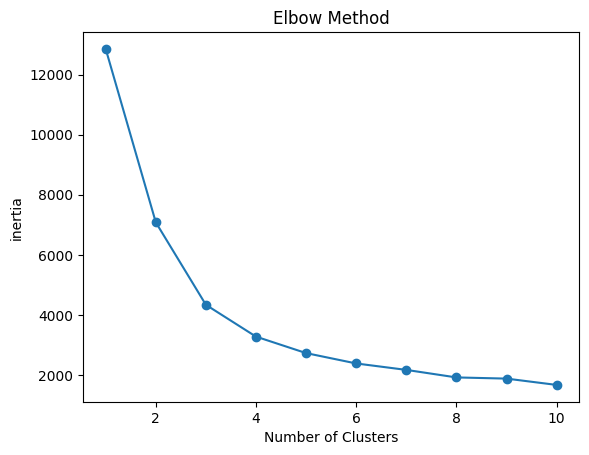

In [82]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data_ol_removed[['recency', 'frequency', 'total_order_value']])

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the inertia for each number of clusters
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('inertia')
plt.show()

<b>Observation:</b> <br>
The elbow method indicates that the optimal number of clusters lies around 3, 4 and 5. The elbow is quit flat and doesn't give a very precise indication.

### 5.4 Implementing K-means clustering <a id="section_5_4"></a>

In [88]:
# Create an instance of KMeans with the optimal number of clusters and fit it to the scaled data
optimal_clusters = 4
kmeans = KMeans(n_clusters= optimal_clusters, init="k-means++",n_init='auto', random_state=42)

# Fit the model to the scaled data
new_df_ol_removed = new_df_ol_removed.copy()
new_df_ol_removed["cluster"] = kmeans.fit_predict(scaled_features)
#(X, y=None, sample_weight=None)

In [89]:
# Calculate the silhouette score for the model.
silhouette_avg = silhouette_score(scaled_features, new_df_ol_removed["cluster"])

print(f'Silhouette Score: {silhouette_avg}')

#Reminder: Values closer to 1 are ideal
                              

Silhouette Score: 0.544070080446038


<b>Interim result:</b> <br>
I have also calculated the silhouette scores for the cluster number 3 and 5. But their silhouette score was smaller and therefore closer to 0.

So proceed with the cluster number 4, which has the most closest score to 1.


### 5.5 Visualize the clusters <a id="section_5_5"></a>

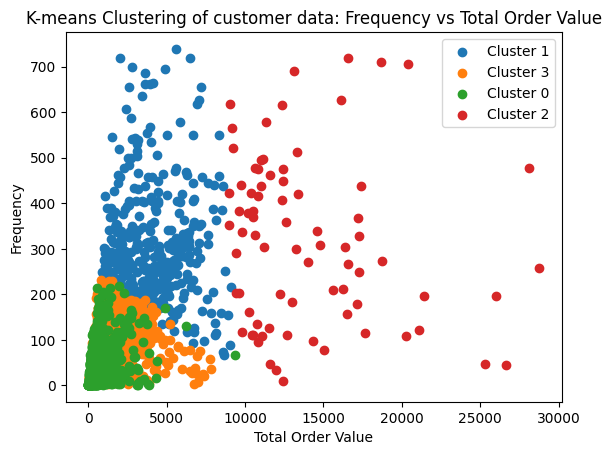

In [100]:
# Create a scatter plot for each clusters
clusters = new_df_ol_removed["cluster"].unique()

for cluster in clusters:
    cluster_data = new_df_ol_removed[new_df_ol_removed["cluster"] == cluster]
    plt.scatter(cluster_data['total_order_value'], 
                cluster_data['frequency'], 
                label=f'Cluster {cluster}') 

# Axes and title
plt.xlabel('Total Order Value')
plt.ylabel('Frequency')
plt.title('K-means Clustering of customer data: Frequency vs Total Order Value')

plt.legend()
plt.show()

<b>First observations:</b> <br>
The Plot shows, that 
- Cluster 0 and 3 share some similarities when it comes to smaller order values. They are mostly identical.
- Cluster 1 and 2 differ more clearly from each other and to Cluster 0 and 3.

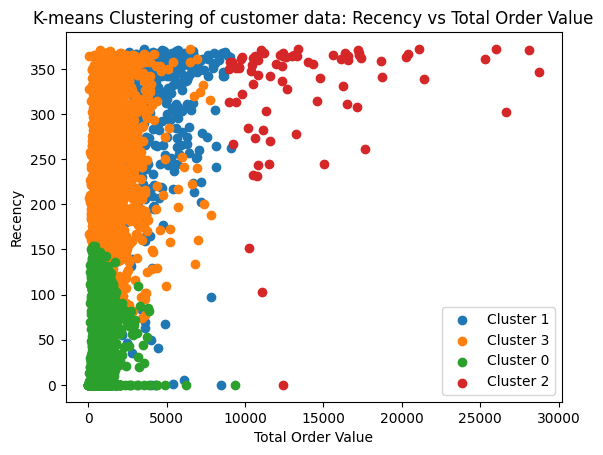

In [104]:
# Create a scatter plot for each clusters
clusters = new_df_ol_removed["cluster"].unique()

for cluster in clusters:
    cluster_data = new_df_ol_removed[new_df_ol_removed["cluster"] == cluster]
    plt.scatter(cluster_data['total_order_value'], 
                cluster_data['recency'], 
                label=f'Cluster {cluster}') 

plt.xlabel('Total Order Value')
plt.ylabel('Recency')
plt.title('K-means Clustering of customer data: Recency vs Total Order Value')
plt.legend()
plt.show()

<b>First observations:</b> <br>
The Plot shows, that 
- Cluster 0 and 3 differ more obvious from each other when it comes to their recency.
- Cluster 1 and 3 are overlapping and share more similarities in their recency. 
- Cluster 1 and 2 differ more clearly from each other.

  

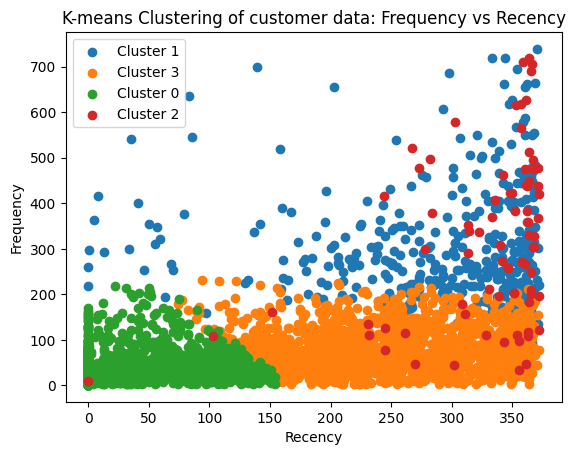

In [132]:
# Create a scatter plot for each clusters
clusters = new_df_ol_removed["cluster"].unique()

for cluster in clusters:
    cluster_data = new_df_ol_removed[new_df_ol_removed["cluster"] == cluster]
    plt.scatter(cluster_data['recency'], 
                cluster_data['frequency'], 
                label=f'Cluster {cluster}') 

# Axes and title
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('K-means Clustering of customer data: Frequency vs Recency')

plt.legend()
plt.show()

<b>First observations:</b> <br>
The Plot shows, that 
- Cluster 0 and 3 differ more obvious from each other when it comes to their recency.
- Cluster 1 and 3 are overlapping and share more similarities in their recency. 
- Cluster 1 and 2 differ more clearly from each other.

In [138]:
# Cluster characteristics in numbers by aggregating the means per cluster

cluster_analysis = new_df_ol_removed.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_order_value': 'mean'
})

In [105]:
cluster_analysis

,recency,frequency,total_order_value
cluster,,,
0,22.876897,31.082631,509.998349
1,290.534177,300.055696,4100.324557
2,326.753247,318.844156,13962.683377
3,245.934028,78.916667,1488.128799


In [140]:
# How many customers belong to which cluster? 
clusters_sizes = new_df_ol_removed["cluster"].value_counts()
print (clusters_sizes)

cluster
0    2372
3    1440
1     395
2      77
Name: count, dtype: int64


<Axes: ylabel='count'>

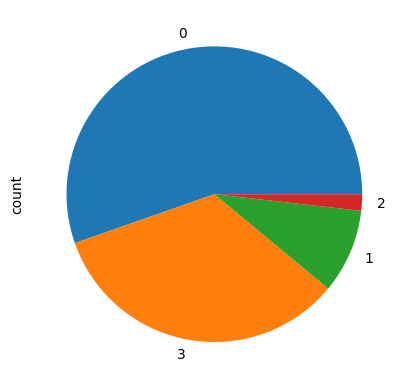

In [146]:
#Let's visualize this numbers quick&easy
clusters_sizes.plot(kind='pie')

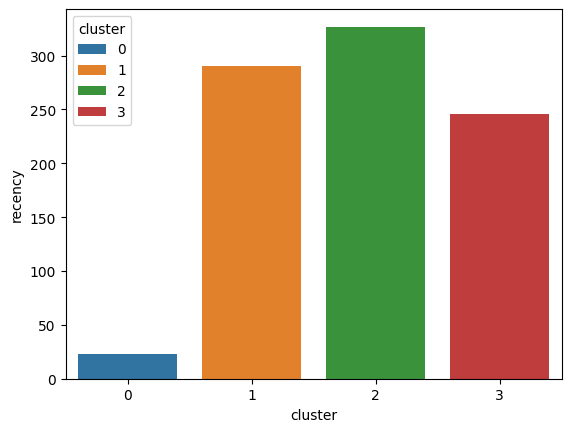

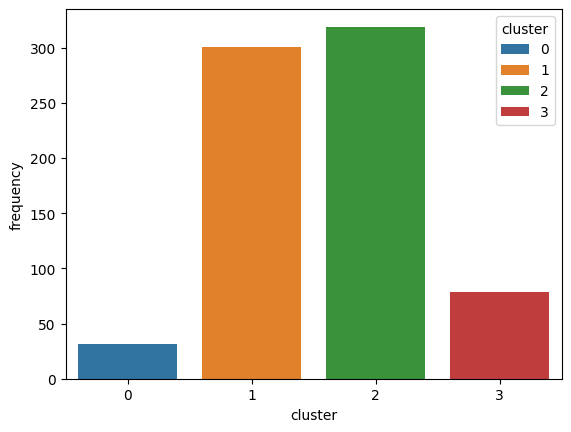

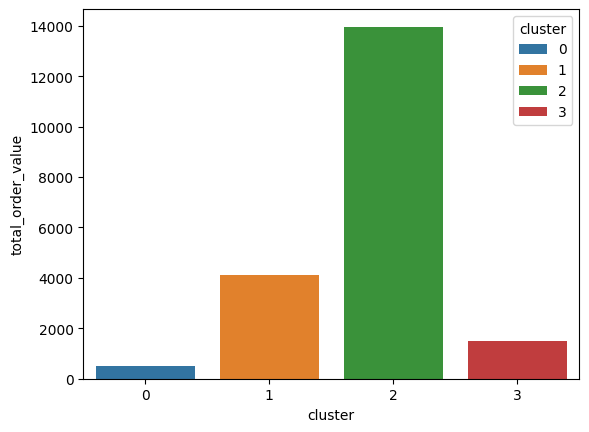

In [139]:
# Calculation the mean for each cluster
avg_df = new_df_ol_removed.groupby(['cluster'], as_index=False).mean()

# Converting into a string 
avg_df['cluster'] = avg_df['cluster'].astype(str)

# Identifying the number of cluster
clusters = avg_df['cluster'].unique()

# Creating a color palette based on the number of clusters
#cmap = plt.get_cmap() 
#colors = cmap(np.linspace(0, 1, len(clusters)))

#wenns auskommentiert ist, hat das keinen Einfluss auf die Darstellung, "palette" wird im nä Schritt aber nochmal heranzgezogen
# Assign colours to the clusters (as strings)
#palette = dict(zip(clusters, colors))

# Creating barplots for each aggregated category by cluster. so we can visualize the size of a cluster by category 

#### Barplot erstellen mit den extrahierten Farben und dem hue-Parameter

for i in list1:
    sns.barplot(x='cluster', y=str(i), data=avg_df, hue='cluster', dodge=False, legend=True)
    plt.show()
    #sns.barplot(x='cluster', y=str(i), data=avg_df, palette=palette, hue='cluster', dodge=False, legend=False)
    





### 5.6. Analysis of the customer clusters <a id="section_5_6"></a>

<b>OBERVATIONS IN CLUSTER 0</b>
- Recency: 22.88 (average days since last purchase)
- Frequency: 31.08 (average number of transactions)
- Total Order Value: 509.99 (average total spend)
- <b>Insights</b>: Customers of cluster 0 have shopped recently, made relatively few transactions and have the lowest average spend. This could indicate new or occasional shoppers who are testing or sporadically purchasing from the store.
- <b>Marketing Strategy</b>: To encourage repeat visits, consider implementing a first-time buyer or a loyalty program, providing welcome discounts, or recommending popular products to increase their purchase frequency and amount.


<b>OBERVATIONS IN CLUSTER 1</b>
- Recency: 290.53 (average days since last purchase)
- Frequency: 300.06 (average number of transactions)
- Total Order Value: 4100.32 (average total spend)
- <b>Insights</b>: These customers haven’t shopped recently but, on average, have made almost the highest number of transactions (in average) with a considerable amount of order value in total in the past. They could be former regular customers who have churned or seasonal shoppers.
- <b>Marketing Strategy</b>: To encourage repeat visits, it could be considered setting up a loyalty program or one for first-time buyers, which offers welcome discounts, or recommends very popular products to increase their purchase in frequency and in amount.


<b>OBERVATIONS IN CLUSTER 2</b>
- Recency: 326.75 (average days since last purchase)
- Frequency: 318.84 (average number of transactions)
- Total Order Value: 13962.68 (average total spend)
- <b>Insights</b>: The average customer of cluster 2 hasn't ordered for the longest time (compared to the other clusters). They have ordered most often in the past and have purchased the hightest amount of order value. This could indicate that these are bulk buyers who rarely buy in large quantities because they have larger storage facilities and the stock has not yet been used up (which may be why they have not yet ordered again) or who have made one-off purchases because they have ordered for a specific project or event.      
- <b>Marketing Strategy</b>: Since three customer clusters, which make up almost half of the customers, order infrequently, a customer survey on ordering behaviour and satisfaction would be conceivable and helpful in gaining further insights. Maybe more personalised disount offers for bulked purchases could reactivate this cluster.

<b>OBERVATIONS IN CLUSTER 3</b>
- Recency: 245.93 (average days since last purchase)
- Frequency: 78.92 (average number of transactions)
- Total Order Value: 1488.13 (average total spend)
- <b>Insights</b>: This customer cluster has also not shopped recently and generated relatively few transactions, but still twice as many as cluster 0 and ordered around three times as much (in terms of order value) as cluster 0.
This behaviour could indicate that, like Cluster 0, the customers are occasional shoppers or first-time buyers, but are willing to take more risks in terms of order volume. Or maybe they were happy to order in the beginning, but then found another source of supply, with which they are more satisfied and this is why they have been ordering elsewhere for some time now.
- <b>Marketing Strategy</b>: This cluster could also be considered for a customer survey in order to find out the exact reasons for the latest reluctance to buy and/or if they are missing specific services or product ranges they find elsewhere.

<b>OVERALL STRATEGY</b><br>
Each cluster offers insights and points of reference that can be leveraged to inform marketing strategies. The objective is to transition customers from a higher frequency of purchases (fewer recent purchases) to a lower frequency (less day inbetween purchases) while increasing the frequency (number of transactions) and overall order value across all customer segments. Personalisation, targeted offers and an understanding of the needs and behaviours of each customer segment are essential for optimising customer value and business growth.

<b>CONCLUSION</b><br>
Customer segmentation using K-Means clustering opens up helpful opportunities to understand and target the different customer groups in retail. Segmenting customers based on their purchasing behaviour enables retailers to develop targeted marketing strategies and optimise the customer experience, which ultimately boosts sales and business growth.